In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [2]:
def reg(x,theta_0,theta_1):
    return theta_1*x + theta_0
def mse(y_hat,y):
    return torch.mean((y_hat-y)**2)

In [3]:
x1_torch = torch.from_numpy(x1)
y_torch = torch.from_numpy(y)
theta_0 = torch.tensor(1.0,requires_grad=True)
theta_1 = torch.tensor(0.0, requires_grad=True)

y_hat = reg(x1_torch,theta_0,theta_1)
loss = mse(y_hat,y_torch)
loss.backward()
theta_0_true_grad = theta_0.grad.item()
theta_1_true_grad = theta_1.grad.item()
print('The True gradient values of theta_0, theta_1:',theta_0_true_grad,theta_1_true_grad)

The True gradient values of theta_0, theta_1: -5.447053909301758 -1.1946825981140137


In [4]:
t0_stochastic_gradients = []
t1_stochastic_gradients = []
for i in range(num_samples):
    theta_0.grad = None
    theta_1.grad = None
    y_hat = reg(x1_torch[i],theta_0,theta_1)
    loss = mse(y_hat,y_torch[i])
    loss.backward()
    t0_stochastic_gradients.append(theta_0.grad.item())
    t1_stochastic_gradients.append(theta_1.grad.item())

t0_avg_grad = sum(t0_stochastic_gradients)/num_samples
t1_avg_grad = sum(t1_stochastic_gradients)/num_samples
print('The True gradient values of theta_0, theta_1:',theta_0_true_grad,theta_1_true_grad)
print('The average value of stochastic gradient of theta_0, theta_1 for all points in the dataset:',t0_avg_grad,t1_avg_grad)

The True gradient values of theta_0, theta_1: -5.447053909301758 -1.1946825981140137
The average value of stochastic gradient of theta_0, theta_1 for all points in the dataset: -5.447053959220648 -1.194682613387704


In [5]:
print('The difference between avg of stochastic and true grad is',abs(theta_0_true_grad-t0_avg_grad),abs(theta_1_true_grad-t1_avg_grad))

The difference between avg of stochastic and true grad is 4.9918890354661016e-08 1.527369031251169e-08


In [40]:
def full_batch_grad(x,y,lr = 0.01,epsilon = 0.001,epochs = 15):
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    epoch = 1
    loss = torch.tensor(float('inf'))
    if epochs is not None:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                theta_0.data = theta_0-lr*theta_0.grad
                theta_1.data = theta_1-lr*theta_1.grad

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            if epoch>=epochs:
                break
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if losses[-1]-losses[-2]<epsilon:
            #         break
    else:
        while True:
            y_hat = reg(x,theta_0,theta_1)
            loss = mse(y_hat,y)
            losses.append(loss)
            loss.backward()
            with torch.no_grad():
                theta_0.data = theta_0-lr*theta_0.grad
                theta_1.data = theta_1-lr*theta_1.grad

            t0_hist.append(theta_0.item())
            t1_hist.append(theta_1.item())
            # print(f'Epoch:{epoch}--> Loss:{loss.item()}')
            theta_0.grad.zero_()
            theta_1.grad.zero_()
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >2:
                if losses[-1]-losses[-2]<epsilon:
                    break
                
    print(f'Full Batch Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses, theta_0.grad.item(), theta_1.grad.item(),t0_hist,t1_hist
def mini_batch_grad(x,y,lr = 0.01,batch_size = 2,epsilon = 0.001, epochs = 15):
    num_samples = x.size(0)
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    avg_epoch_loss = float('inf')
    num_samples_per_batch = num_samples//batch_size
    epoch = 1
    if epochs is not None:
        while True:
            batch = torch.randperm(num_samples)
            epoch_loss = 0
            for i in range(0,num_samples, batch_size):
                indice = batch[i:i+batch_size]
                mini_x,mini_y = x[indice],y[indice]
                mini_y_hat = reg(mini_x, theta_0,theta_1)
                loss = mse(mini_y_hat,mini_y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples_per_batch
            losses.append(avg_epoch_loss)
            # print(f'Epoch:{epoch}--> Avg Epoch Loss:{avg_epoch_loss}')
            epoch += 1
            if epoch >=epochs:
                break
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if losses[-1]-losses[-2]<epsilon:
            #         break
            
    else:
        while True:
            batch = torch.randperm(num_samples)
            epoch_loss = 0
            for i in range(0,num_samples, batch_size):
                indice = batch[i:i+batch_size]
                mini_x,mini_y = x[indice],y[indice]
                mini_y_hat = reg(mini_x, theta_0,theta_1)
                loss = mse(mini_y_hat,mini_y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad
                theta_0.grad.zero_()
                theta_1.grad.zero_()

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
            avg_epoch_loss = epoch_loss/num_samples_per_batch
            losses.append(avg_epoch_loss)
            # print(f'Epoch:{epoch}--> Avg Epoch Loss:{avg_epoch_loss}')
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >2:
                if losses[-1]-losses[-2]<epsilon:
                    break

    print(f'Mini Batch Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses,theta_0.grad.item(),theta_1.grad.item(),t0_hist,t1_hist
    
def stochastic_grad(x, y, lr=0.01, epsilon=0.001, epochs= 15):
    num_samples = x.size(0)
    theta_0 = torch.tensor(0.0,requires_grad=True)
    theta_1 = torch.tensor(0.0,requires_grad=True)
    t0_hist = [theta_0.item()]
    t1_hist = [theta_1.item()]
    losses = []
    avg_epoch_loss = float('inf')
    epoch = 1
    if epochs is not None:
        while True:
            epoch_loss = 0
            for i in range(num_samples):
                y_hat = reg(x[i], theta_0,theta_1)
                loss =mse(y_hat, y[i])
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad

                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples
            losses.append(avg_epoch_loss)
            # print(f'Epoch:{epoch}-->Avg Epoch Loss:{avg_epoch_loss}')
            epoch += 1
            if epoch>= epochs:
                break
            # if epoch>1000 and epoch%100 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            # if len(losses) >2:
            #     if losses[-1]-losses[-2]<epsilon:
            #         break
    else:
        while True:
            epoch_loss = 0
            for i in range(num_samples):
                y_hat = reg(x, theta_0,theta_1)
                loss =mse(y_hat, y)
                epoch_loss += loss.item()
                loss.backward()
                with torch.no_grad():
                    theta_0.data -= lr*theta_0.grad
                    theta_1.data -= lr*theta_1.grad
                t0_hist.append(theta_0.item())
                t1_hist.append(theta_1.item())
                theta_0.grad.zero_()
                theta_1.grad.zero_()
            avg_epoch_loss = epoch_loss/num_samples
            # print(f'Epoch:{epoch}-->Avg Epoch Loss:{avg_epoch_loss}')
            losses.append(avg_epoch_loss)
            epoch += 1
            # if epoch>=400 and epoch%50 == 0:
            #     if losses[-5:].count(losses[-1])== 5:
            #         break
            if len(losses) >2:
                if losses[-1]-losses[-2]<epsilon:
                    break

    
    print(f'Stochastic Gradient Descent---->No of Epochs Caliculated:{epoch} Final loss:{losses[-1]}')
    return losses, theta_0.grad.item(), theta_1.grad.item(),t0_hist,t1_hist

In [45]:
losses_full, theta_0_full, theta_1_full, t0_hist_full, t1_hist_full = full_batch_grad(x1_torch, y_torch,epochs = 500)
losses_mini, theta_0_mini, theta_1_mini, t0_hist_mini, t1_hist_mini = mini_batch_grad(x1_torch,y_torch, epochs = 500)
losses_stoc, theta_0_stoc, theta_1_stoc, t0_hist_stoc, t1_hist_stoc = stochastic_grad(x1_torch,y_torch, epochs = 500)

Full Batch Gradient Descent---->No of Epochs Caliculated:500 Final loss:0.6024839615785254
Mini Batch Gradient Descent---->No of Epochs Caliculated:500 Final loss:0.6035544549934323
Stochastic Gradient Descent---->No of Epochs Caliculated:500 Final loss:0.6110106790944151


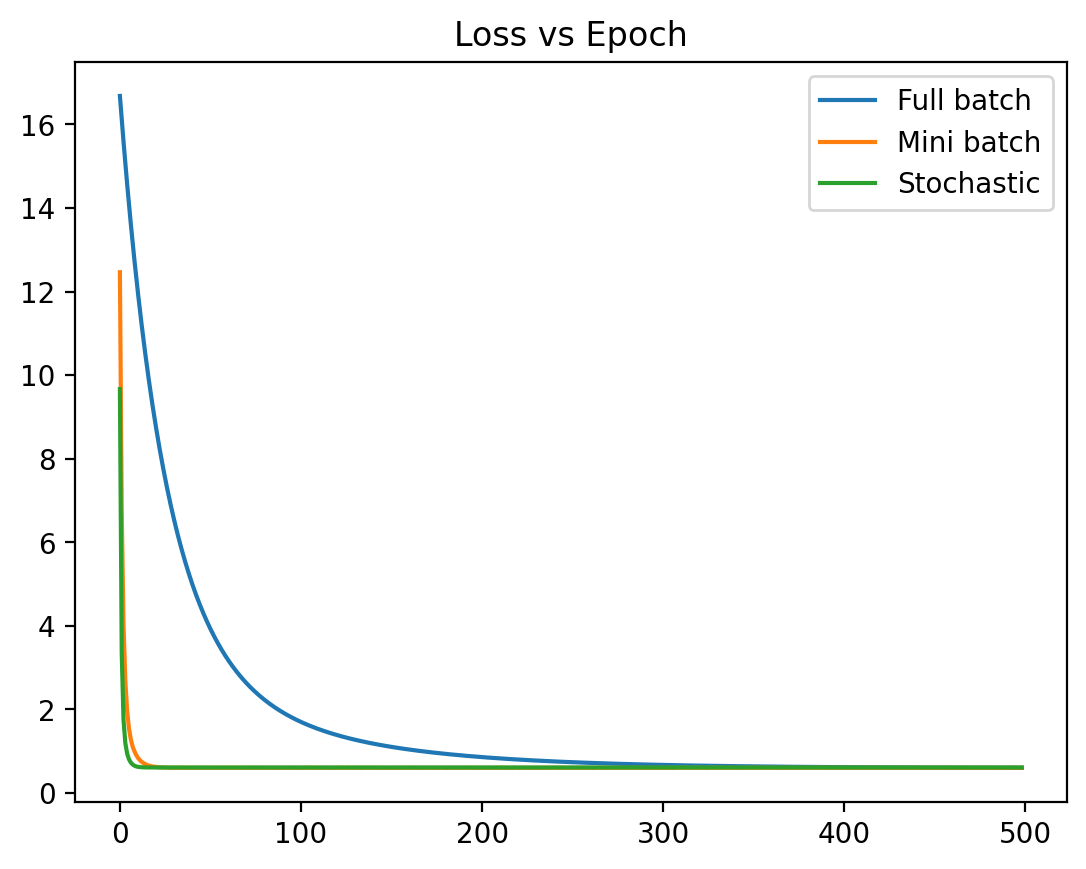

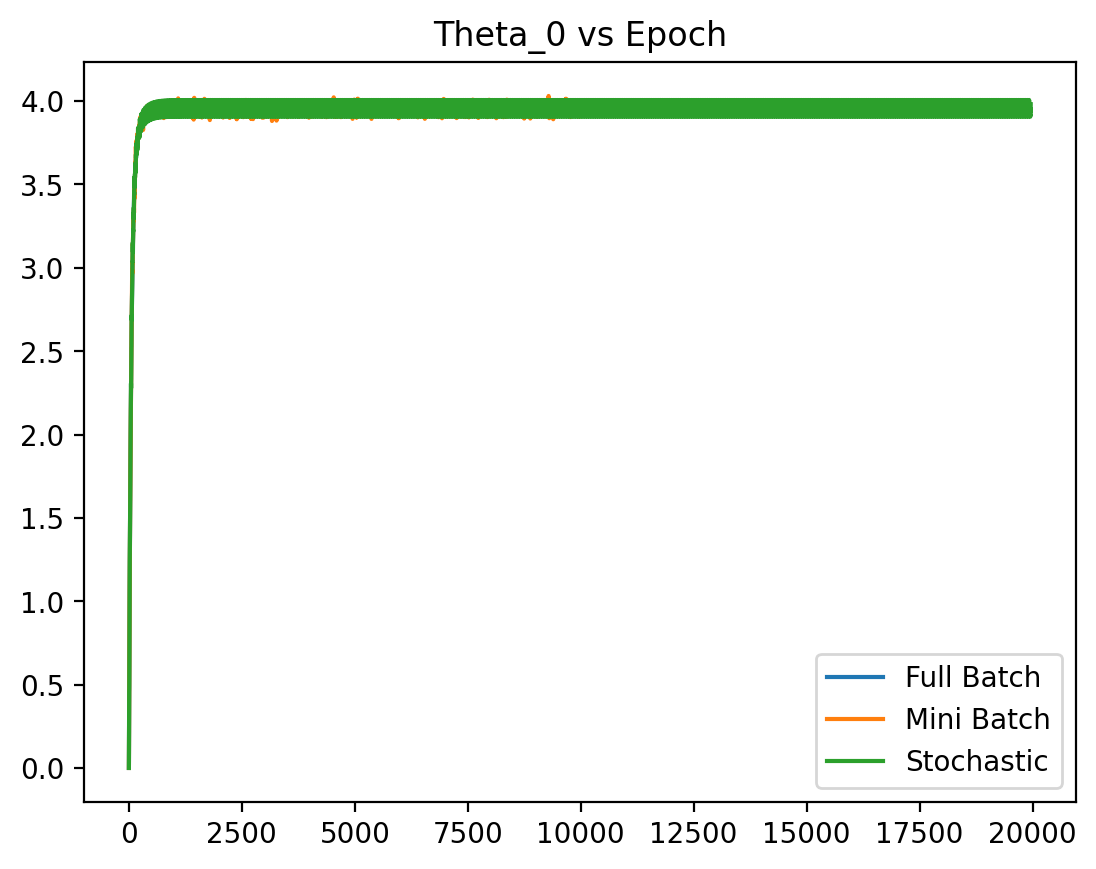

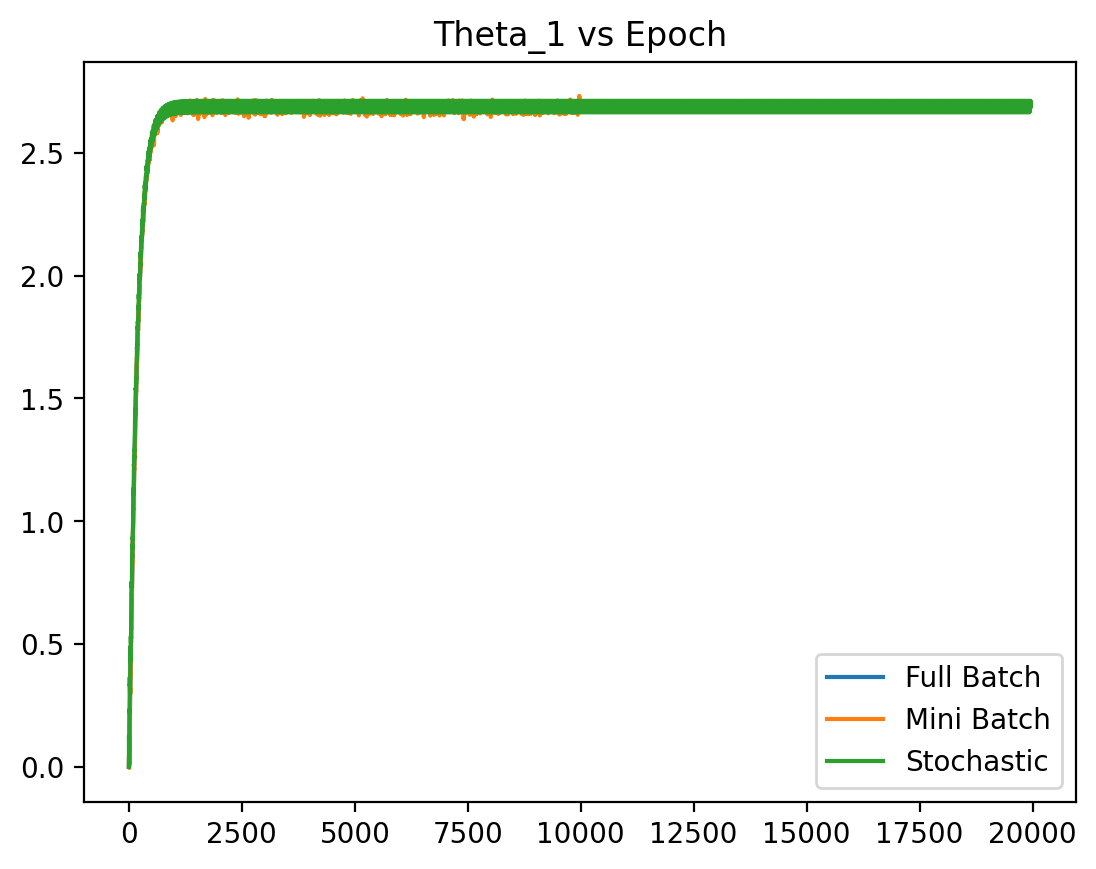

In [46]:
plt.plot(losses_full, label = 'Full batch')
plt.plot(losses_mini, label = 'Mini batch')
plt.plot(losses_stoc, label = 'Stochastic')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()
plt.plot(t0_hist_full, label = 'Full Batch')
plt.plot(t0_hist_mini, label = 'Mini Batch')
plt.plot(t0_hist_stoc, label = 'Stochastic')
plt.legend()
plt.title('Theta_0 vs Epoch')
plt.show()
plt.plot(t1_hist_full, label = 'Full Batch')
plt.plot(t1_hist_mini, label = 'Mini Batch')
plt.plot(t1_hist_stoc, label = 'Stochastic')
plt.legend()
plt.title('Theta_1 vs Epoch')
plt.show()

In [47]:
theta0_range = np.linspace(-2, 8, 100)
theta1_range = np.linspace(-1, 6, 100)
theta0_grid, theta1_grid = np.meshgrid(theta0_range, theta1_range)
loss_grid = np.zeros_like(theta0_grid)
for i in range(theta0_grid.shape[0]):
    for j in range(theta0_grid.shape[1]):
        y_hat = reg(x1_torch, theta0_grid[i,j], theta1_grid[i,j])
        loss_grid[i, j] = mse(y_hat, y_torch)

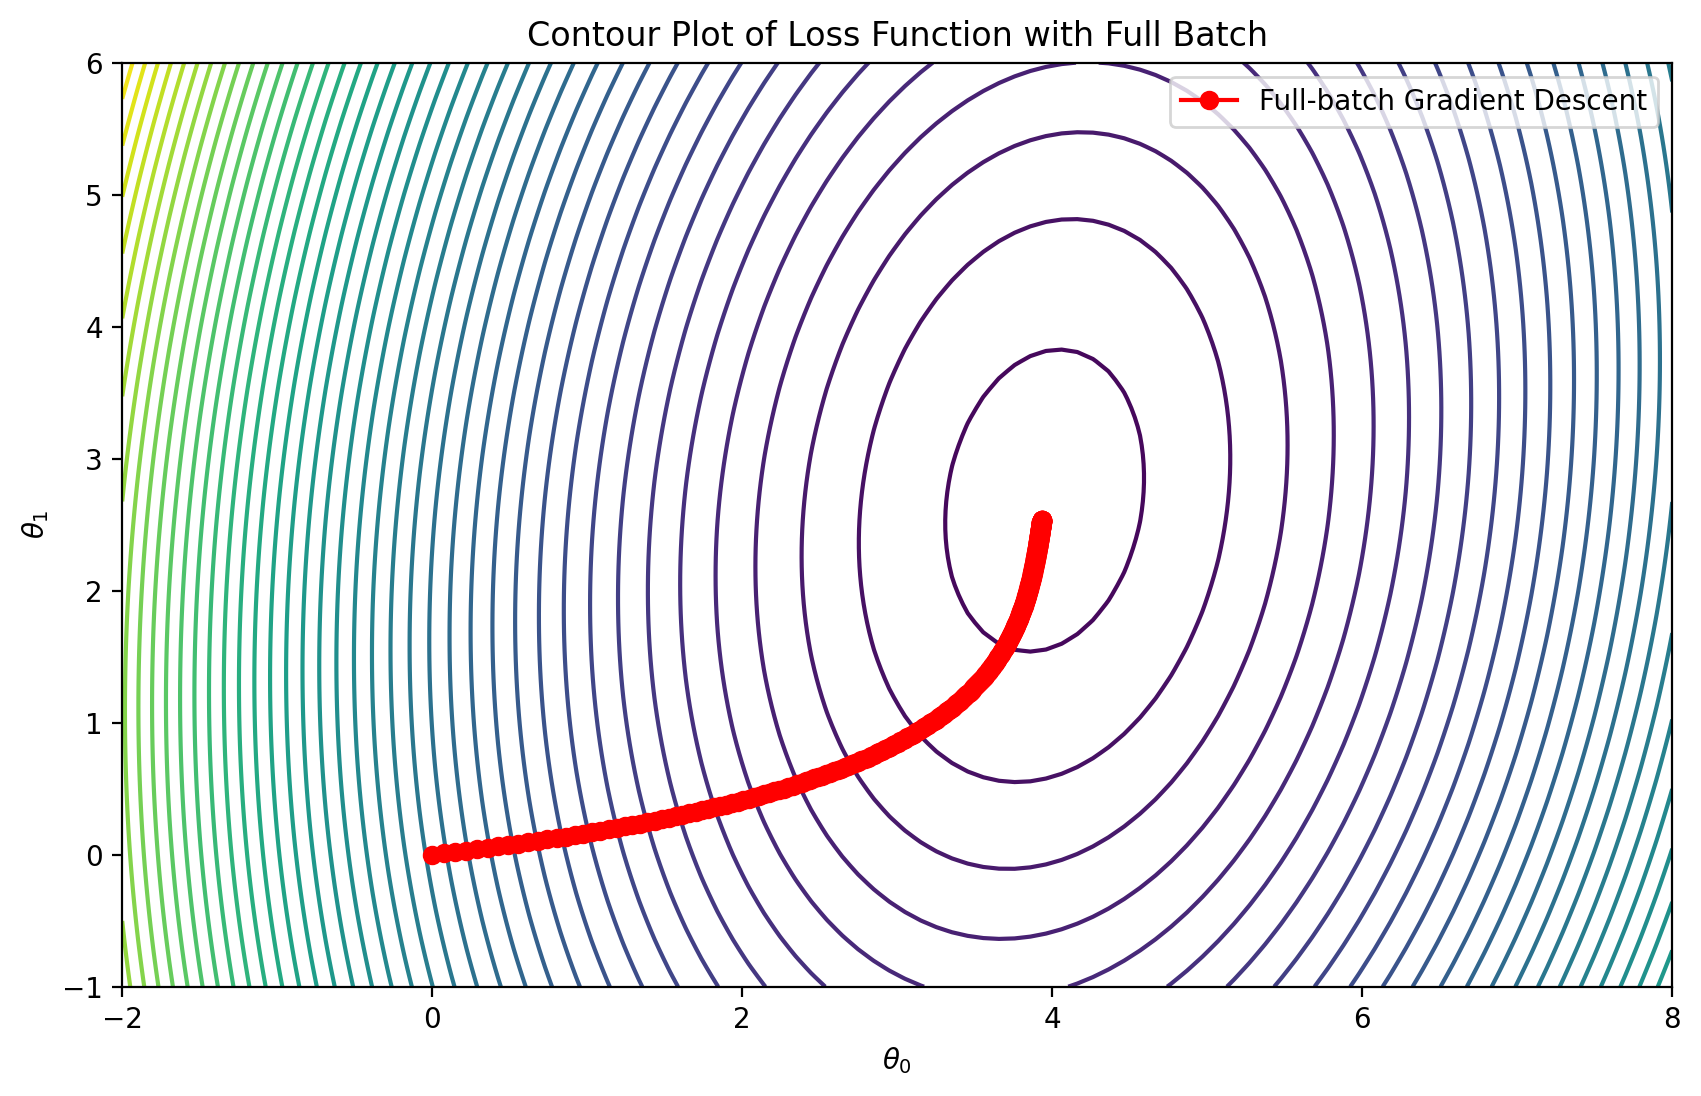

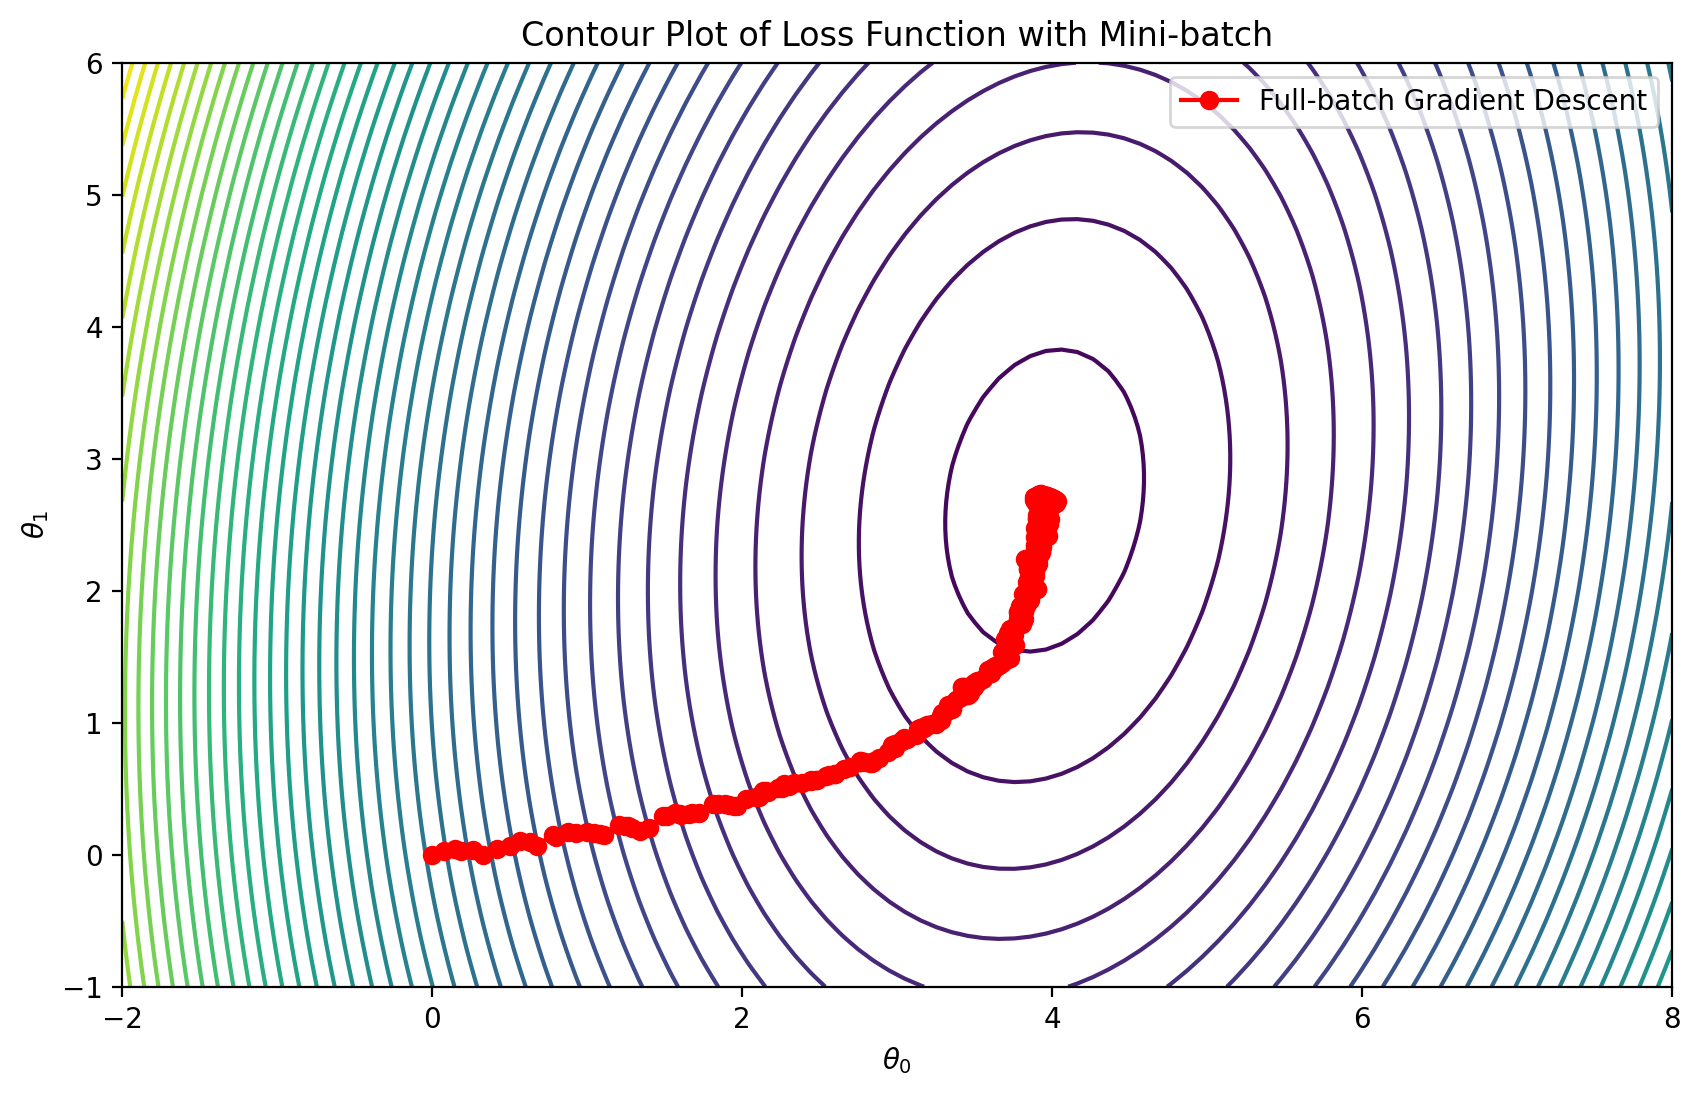

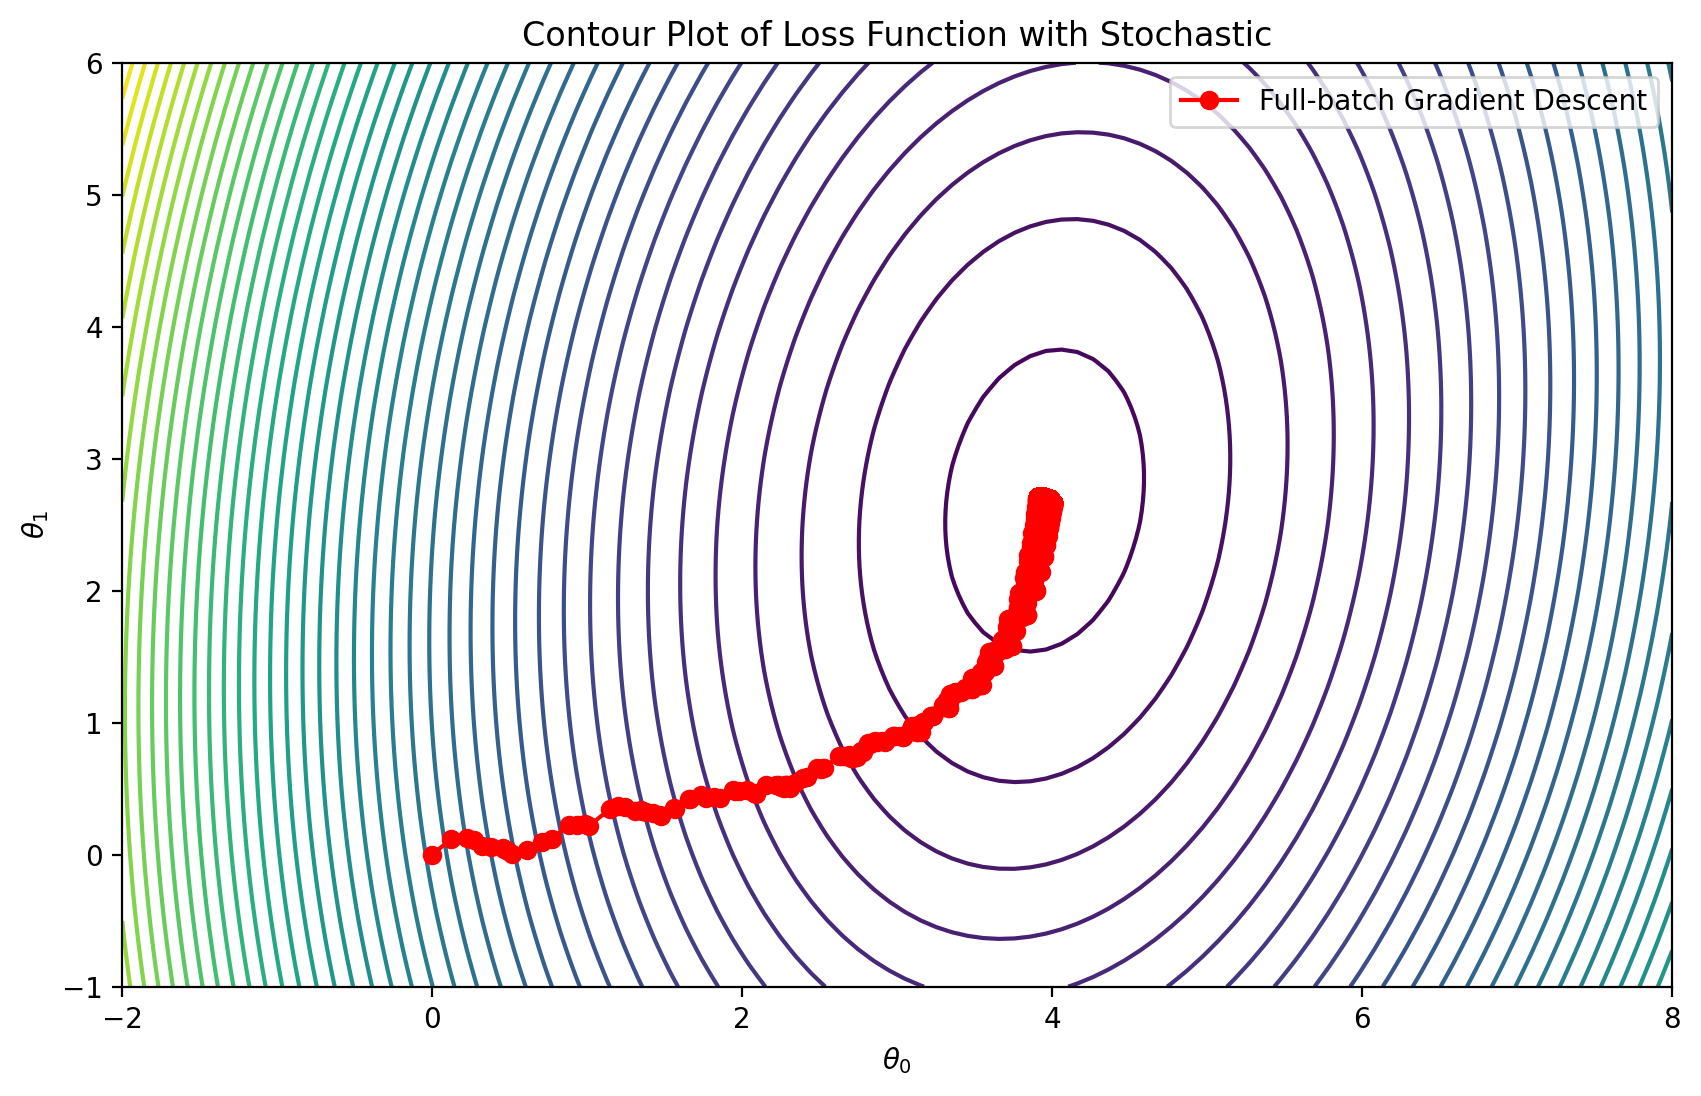

In [48]:
plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_full, t1_hist_full, marker='o', color='r', label='Full-batch Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Full Batch')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_mini, t1_hist_mini, marker='o', color='r', label='Full-batch Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Mini-batch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.contour(theta0_grid, theta1_grid, loss_grid, levels=50, cmap='viridis')
plt.plot(t0_hist_stoc, t1_hist_stoc, marker='o', color='r', label='Full-batch Gradient Descent')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Loss Function with Stochastic')
plt.legend()
plt.show()